# Testing AmaroX

This section is added to test different functions inside AmaroX. 

## Import the library under your consideration

In [1]:
from AmaroX.Convolutional import *

2025-09-21 20:13:58.690542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-21 20:14:01.688607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/alan-amaro/miniconda3/envs/transmittance/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
from AmaroX.data_manipulation import *

In [3]:
from AmaroX.ai_functions import *

## Data

In [4]:
n = 1000
size = [
    1080000//n,
    108000//n, 
    12000//n
]

In [6]:
data = load_data_normalization_sample_General(
    folder = '/media/alan-amaro/XicoDisk/TrainTestVal_Transmittance3',
    size = size
)

In [7]:
show_dimensions(data)



--------------------------------------------------
The dimensions of each dataset corresponds to:
--------------------------------------------------

Train: 
    x: (1080, 911, 1)
    y: (1080, 1)

Test: 
    x: (108, 911, 1)
    y: (108, 1)

Val:
    x: (12, 911, 1)
    y: (12, 1)
    


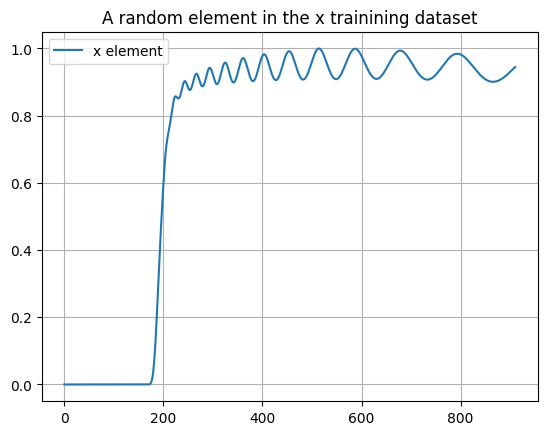

The corresponding y element -> [1748.]


In [8]:
plot_xy(data)

In [9]:
x_train, y_train, x_test, y_test, x_val, y_val = data
del data 

In [10]:
get_gpu(0)

2025-09-21 20:14:28.450507: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-21 20:14:29.778868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-21 20:14:29.779674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
name = 'test'
folder_path = './models'
final_path = os.path.join(folder_path, name)

In [12]:
callbacks = standard_callbacks(folder_name= name, 
                               folder_path= folder_path, 
                               patiences= [5, 1000])

In [25]:
def UNET_ConvDown(inputs: tf.Tensor, filters: int, power_of_two: int, kernel:int, act_func: str, pad_type:str, 
                pool:int, stride:int, WIC:str, WRC, stride_conv: int = 1, pool_op = 'AP', pool_bool: bool = True) -> tf.Tensor:
    '''
        Applies a downsampling block consisting of two convolutional layers, 
        batch normalization, activation functions, and optional pooling.
    
        Args:
            inputs (tf.Tensor): Input tensor of shape (batch_size, sequence_length, channels).
            filters (int): Base number of filters (multiplied by `2^power_of_two`).
            power_of_two (int): Exponent to scale filters as `filters * (2^power_of_two)`.
            kernel (int): Kernel size for convolutional layers.
            act_func (str): Activation function name (e.g., 'relu', 'sigmoid').
            pad_type (str): Padding type for pooling ('same' or 'valid').
            pool (int): Pooling window size.
            stride (int): Stride for pooling operations.
            WIC (str): Weight initializer for convolutional layers.
            WRC: Weight regularizer for convolutional layers.
            stride_conv (int, optional): Stride for convolutional layers. Defaults to 1.
            pool_op (str, optional): Pooling operation: 'AP' (AveragePooling), 'MP' (MaxPooling), or None. Defaults to 'AP'.
            pool_bool (bool, optional): If True, apply pooling and return both pooled and pre-pooling tensors. Defaults to True.
    
        Returns:
            tf.Tensor: If `pool_bool = False`, returns the activated output after convolutions.
            tuple[tf.Tensor, tf.Tensor]: If `pool_bool = True`, returns:
                - Pooled output tensor
                - Pre-pooling activation tensor (skip connection)
    
        Architecture:
            1. Conv1D → BatchNorm → Activation
            2. Conv1D → BatchNorm → Activation
            3. (Optional) Pooling (Average/Max) or identity pass
            '''

    n, f = power_of_two, filters

    Conv1 = keras.layers.Conv1D(
        filters = int( (2**n) *f),
        kernel_size = kernel,
        strides = stride_conv, 
        padding = 'same',
        kernel_initializer = WIC, 
        kernel_regularizer = WRC
    )(inputs)
    
    BN = keras.layers.BatchNormalization()(Conv1)
    Act = keras.layers.Activation(activation = act_func)(BN)

    Conv2 = keras.layers.Conv1D(
        filters = int( (2**n) *f),
        kernel_size = kernel,
        strides = stride_conv, 
        padding = 'same',
        kernel_initializer = WIC, 
        kernel_regularizer = WRC
    )(Act)

    BN = keras.layers.BatchNormalization()(Conv2)
    Act = keras.layers.Activation(activation = act_func)(BN)

    if pool_bool:

        if pool_op == 'AP':
            AP = keras.layers.AveragePooling1D(
                pool_size = pool,
                strides = stride, 
                padding = pad_type
                )(Act)
        
        elif pool_op == 'MP':
            AP = keras.layers.MaxPooling1D(
            pool_size = pool,
            strides = stride, 
            padding = pad_type
            )(Act)

        elif pool_op == None:
            AP = Act
            
        return AP, Act 

    else:
        
        return Act 

In [26]:
def UNET_ConvUp_US(inputs: tf.Tensor, block: tf.Tensor, filters: int, power_of_two: int, kernel:int, act_func: str, WIC:str, WRC:str, 
                   stride_conv: int = 1) -> tf.Tensor:
    '''
    Performs upsampling and concatenation with skip connection followed by two convolutional layers.
    Handles dimension matching between encoder and decoder paths with automatic padding.

    Args:
        inputs (tf.Tensor): Input tensor from previous decoder layer.
        block (tf.Tensor): Skip connection tensor from corresponding encoder layer.
        filters (int): Base number of filters (multiplied by `2^power_of_two`).
        power_of_two (int): Exponent to scale filters as `filters * (2^power_of_two)`.
        kernel (int): Kernel size for convolutional layers.
        act_func (str): Activation function name (e.g., 'relu', 'sigmoid').
        WIC (str): Weight initializer for convolutional layers.
        WRC (str): Weight regularizer for convolutional layers.
        stride_conv (int, optional): Stride for convolutional layers. Defaults to 1.

    Returns:
        tf.Tensor: Processed tensor after upsampling, concatenation, and convolutions.

    Architecture:
        1. Calculate required upsampling size and padding
        2. Upsample input tensor
        3. Apply zero-padding if necessary for dimension matching
        4. Concatenate with skip connection
        5. Apply two Conv1D → BatchNorm → Activation blocks

    Dimension Handling:
        - Automatically calculates upsampling factor (n) and padding (m)
        - Handles both divisible and non-divisible dimension relationships
        - Uses zero-padding for fractional dimension adjustments
    '''

    _f, _n = filters, power_of_two
    
    # ---- UpSampling Section 
    dim_in, dim_out = inputs.shape[1], block.shape[1] # Get the corresponding dimensions 
    
    n = dim_out//dim_in
    r = dim_out%dim_in
    m = dim_out - (n*dim_in)

    if r == 0 :
        _Up = keras.layers.UpSampling1D(size = n)(inputs)
        
    elif r!=0: 
        _Up = keras.layers.UpSampling1D(size = n)(inputs)
        _Up = keras.layers.ZeroPadding1D(padding = (0,m))(_Up)
    
    # ---- Concatenate Section
    _Up =keras.layers.Concatenate()([_Up, block]) # Match the UpSampled and the corresponding block

    # ---- Process the block 

    Conv1 = keras.layers.Conv1D(
        filters = int( (2**_n) *_f),
        kernel_size = kernel,
        strides = stride_conv, 
        padding = 'same',
        kernel_initializer = WIC, 
        kernel_regularizer = WRC
    )(_Up)
    
    BN = keras.layers.BatchNormalization()(Conv1)
    Act = keras.layers.Activation(activation = act_func)(BN)

    Conv2 = keras.layers.Conv1D(
        filters = int( (2**_n) *_f),
        kernel_size = kernel,
        strides = stride_conv, 
        padding = 'same',
        kernel_initializer = WIC, 
        kernel_regularizer = WRC
    )(Act)

    BN = keras.layers.BatchNormalization()(Conv2)
    Act = keras.layers.Activation(activation = act_func)(BN)

    return Act

In [27]:
def Up_Match_USConv(inputs: tf.Tensor, block: tf.Tensor):
    '''
    Description:
        This function takes into a inputs and scale it using UpSampling1D to the desire dimension (the input layer). 
        As the UpSampling conserve the number of filters, a posterior convolutional layer is required.

    Args:
        inputs (tf.Tensor): Tensor to be UpSampled 
        block (tf.Tensor): Tensor to match dimensions with
    '''
    # ---- UpSampling Section 
    dim_in, dim_out = inputs.shape[1], block.shape[1] # Get the corresponding dimensions 
    n = dim_out//dim_in
    r = dim_out%dim_in
    m = dim_out - (n*dim_in)

    if r == 0 :
        _Up = keras.layers.UpSampling1D(size = n)(inputs)
        
    elif r!=0: 
        _Up = keras.layers.UpSampling1D(size = n)(inputs)
        _Up = keras.layers.ZeroPadding1D(padding = (0,m))(_Up)


    return _Up

In [42]:
def G_UNET(inputs: tf.Tensor, layers:int, unet_kernel: list, WIC:str, WRC, pad_type:str, unet_act_func = 'leaky_relu', 
           pool: int = 12, stride: int = 3, final_func_act: str = 'relu', stride_conv: int = 1, pool_op:str = 'AP', 
           pool_bool: bool = True):
    '''
    Constructs a complete 1D U-Net generator with symmetric encoder-decoder architecture
    and skip connections between corresponding encoder and decoder blocks.

    Args:
        inputs (tf.Tensor): Input tensor of shape (batch_size, sequence_length, channels).
        layers (int): Base number of filters (scaled exponentially across layers).
        unet_kernel (list): List of kernel sizes for each encoder/decoder block.
        WIC (str): Weight initializer for all convolutional layers.
        WRC: Weight regularizer for all convolutional layers.
        pad_type (str): Padding type for pooling operations ('same' or 'valid').
        unet_act_func (str, optional): Activation function for intermediate layers. Defaults to 'leaky_relu'.
        pool (int, optional): Pooling window size. Defaults to 12.
        stride (int, optional): Stride for pooling operations. Defaults to 3.
        final_func_act (str, optional): Activation function for final output layer. Defaults to 'relu'.
        stride_conv (int, optional): Stride for convolutional layers. Defaults to 1.
        pool_op (str, optional): Pooling operation type: 'AP' (AveragePooling) or 'MP' (MaxPooling). Defaults to 'AP'.
        pool_bool (bool, optional): Whether to apply pooling in encoder blocks. Defaults to True.

    Returns:
        tf.Tensor: Output tensor with the same temporal dimensions as input, processed through U-Net.

    Architecture:
        Encoder Path:
          - Series of downsampling blocks (UNET_ConvDown)
          - Each block doubles the number of filters (2^power_of_two scaling)
          - Skip connections are stored for decoder path

        Bottleneck:
          - Highest abstraction level without pooling
          - Maximum filter count (2^(len(unet_kernel)-1 * layers)

        Decoder Path:
          - Series of upsampling blocks (UNET_ConvUp_US)
          - Each block halves the number of filters
          - Skip connections from encoder are concatenated
          - Uses learned upsampling with dimension matching

        Final Layer:
          - 1x1 convolution to produce output
          - Dimension matching with original input

    Notes:
        - The number of encoder/decoder blocks is determined by the length of unet_kernel
        - Uses exponential filter scaling (2^power_of_two) throughout the network
        - Automatically handles dimension matching between encoder and decoder paths
    '''

    _blocks = [] 

    # Enconder Section ----------------- ConvDown
    #UNET_ConvDown(inputs: tf.Tensor, filters: int, power_of_two: int, kernel:int, act_func: str, pad_type:str, 
    #            pool:int, stride:int, WIC:str, WRC, stride_conv: int = 1, pool_op = 'AP', pool_bool: bool = True) -> tf.Tensor:

    
    Encoder, Concat = UNET_ConvDown(
        inputs= inputs, 
        filters = layers, 
        power_of_two = 0, 
        kernel = unet_kernel[0], 
        act_func = unet_act_func, 
        pad_type = pad_type, 
        pool = pool, 
        stride = stride, 
        WIC = WIC, 
        WRC = WRC, 
        stride_conv = stride_conv, 
        pool_op = pool_op, 
        pool_bool = pool_bool) 
    
    _blocks.append(Concat) # Save the first block

    for i in range(1, len(unet_kernel) - 1 ):
        Encoder, Concat = UNET_ConvDown(
            inputs= Encoder, 
            filters = layers, 
            power_of_two = i, 
            kernel = unet_kernel[i], 
            act_func = unet_act_func, 
            pad_type = pad_type, 
            pool = pool, 
            stride = stride, 
            WIC = WIC, 
            WRC = WRC, 
            stride_conv = stride_conv, 
            pool_op = pool_op, 
            pool_bool = pool_bool) 
        
        _blocks.append(Concat) # Save each block
    
    # Bottleneck -------------------------------------
    Bottleneck = UNET_ConvDown(
            inputs= Encoder, 
            filters = layers, 
            power_of_two = len(unet_kernel)-1, 
            kernel = unet_kernel[-1], 
            act_func = unet_act_func, 
            pad_type = pad_type, 
            pool = pool, 
            stride = stride, 
            WIC = WIC, 
            WRC = WRC, 
            stride_conv = stride_conv, 
            pool_op = pool_op, 
            pool_bool = False) 
    
    
    # Decoder Section ---------------- ConvUp_US
    # UNET_ConvUp_US(inputs: tf.Tensor, block: tf.Tensor, filters: int, power_of_two: int, kernel:int, act_func: str, WIC:str, WRC:str, 
    #               stride_conv: int = 1) -> tf.Tensor:
    Decoder = UNET_ConvUp_US(
        inputs = Bottleneck, 
        block = _blocks[-1], 
        filters= layers, 
        power_of_two= len(unet_kernel)-2, 
        kernel= unet_kernel[-2], 
        act_func = unet_act_func, 
        WIC=WIC, 
        WRC=WRC, 
        stride_conv= stride_conv)
    
    
    i = len(unet_kernel) -3
    for _block in _blocks[ -2: : -1]:        
        Decoder = UNET_ConvUp_US(
            inputs = Decoder, 
            block = _block, 
            filters= layers, 
            power_of_two= i, 
            kernel= unet_kernel[i], 
            act_func = unet_act_func, 
            WIC=WIC, 
            WRC=WRC, 
            stride_conv = stride_conv)
        
        i -= 1

    Final_Stage = keras.layers.Conv1D( 
        filters = 1, 
        kernel_size = 1,
        kernel_initializer= WIC,
        activation = final_func_act)( 
            Up_Match_USConv(Decoder, inputs) 
        )

    return Final_Stage

In [43]:
G_UNET

<function __main__.G_UNET(inputs: tensorflow.python.framework.tensor.Tensor, layers: int, unet_kernel: list, WIC: str, WRC, pad_type: str, unet_act_func='leaky_relu', pool: int = 12, stride: int = 3, final_func_act: str = 'relu', stride_conv: int = 1, pool_op: str = 'AP', pool_bool: bool = True)>

In [44]:
def _mod(): 

    inputs = keras.layers.Input((911,1))
    
    _UNET = G_UNET(
        inputs = inputs,
        layers = 9, 
        unet_kernel = [25, 15, 5],
        WIC = 'he_normal', 
        WRC = keras.regularizers.L1L2(l1 = 1e-3, l2=1e-3), 
        pad_type = 'valid',
        unet_act_func= 'leaky_relu', 
        pool = 12, 
        stride = 3, 
        final_func_act = 'relu', 
        stride_conv = 1, 
        pool_op = 'AP'
        
    )

    return keras.models.Model(inputs = inputs, outputs = _UNET)

In [45]:
modelo = _mod()

In [46]:
modelo.compile(optimizer = keras.optimizers.Adam(),
                    loss = 'mean_absolute_error',
                    metrics = ['mean_absolute_error'])

In [47]:
modelo.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 911, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 911, 9)    │        234 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 911, 9)    │         36 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 911, 9)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 911, 9)    │      2,034 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 911, 9)    │         36 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 911, 9)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_6 │ (None, 300, 9)    │          0 │ activation_27[0]… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 300, 18)   │      2,448 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 18)   │         72 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 300, 18)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 300, 18)   │      4,878 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 18)   │         72 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 300, 18)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_7 │ (None, 97, 18)    │          0 │ activation_29[0]… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 97, 36)    │      3,276 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 36)    │        144 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 97, 36)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 47,710 (186.37 KB)

 Trainable params: 47,350 (184.96 KB)

 Non-trainable params: 360 (1.41 KB)

In [48]:
get_plot_model(modelo, folder_path= final_path)

In [ ]:
model_trained = model_training(modelo, 
                               folder_path = final_path, 
                               batch_size = 32, 
                               num_epochs = 1000, 
                               x_train = x_train, 
                               y_train = x_train, 
                               x_val = x_val, 
                               y_val = x_val, 
                               callbacks = callbacks)